# Customer Analysis

In [1]:
# -------------------------------------------------------------------
# Setup cell — place this at the top of every analysis notebook
# -------------------------------------------------------------------
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import chi2_contingency

df = pd.read_csv("../datasets/customer_shopping_data_v10.csv")
sns.set_theme(style="whitegrid")

color1 = '#FF9E9D'  # Coral Pink
color2 = '#FFC785'  # Peach
color3 = '#FFF59D'  # Light Lemon
color4 = '#A0E6A6'  # Mint Green
color5 = '#87C8FF'  # Sky Blue
color6 = '#C4A2FF'  # Lavender
color7 = "#FFD6A5"  # Soft Orange
color8 = "#B5EAD7"  # Pastel Turquoise

1. age ↔ total_spend <br>
Does the total spend increase with age?

                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9132
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.344
Time:                        11:36:44   Log-Likelihood:                -306.43
No. Observations:                  52   AIC:                             616.9
Df Residuals:                      50   BIC:                             620.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2493.8585     38.027     65.581      0.0

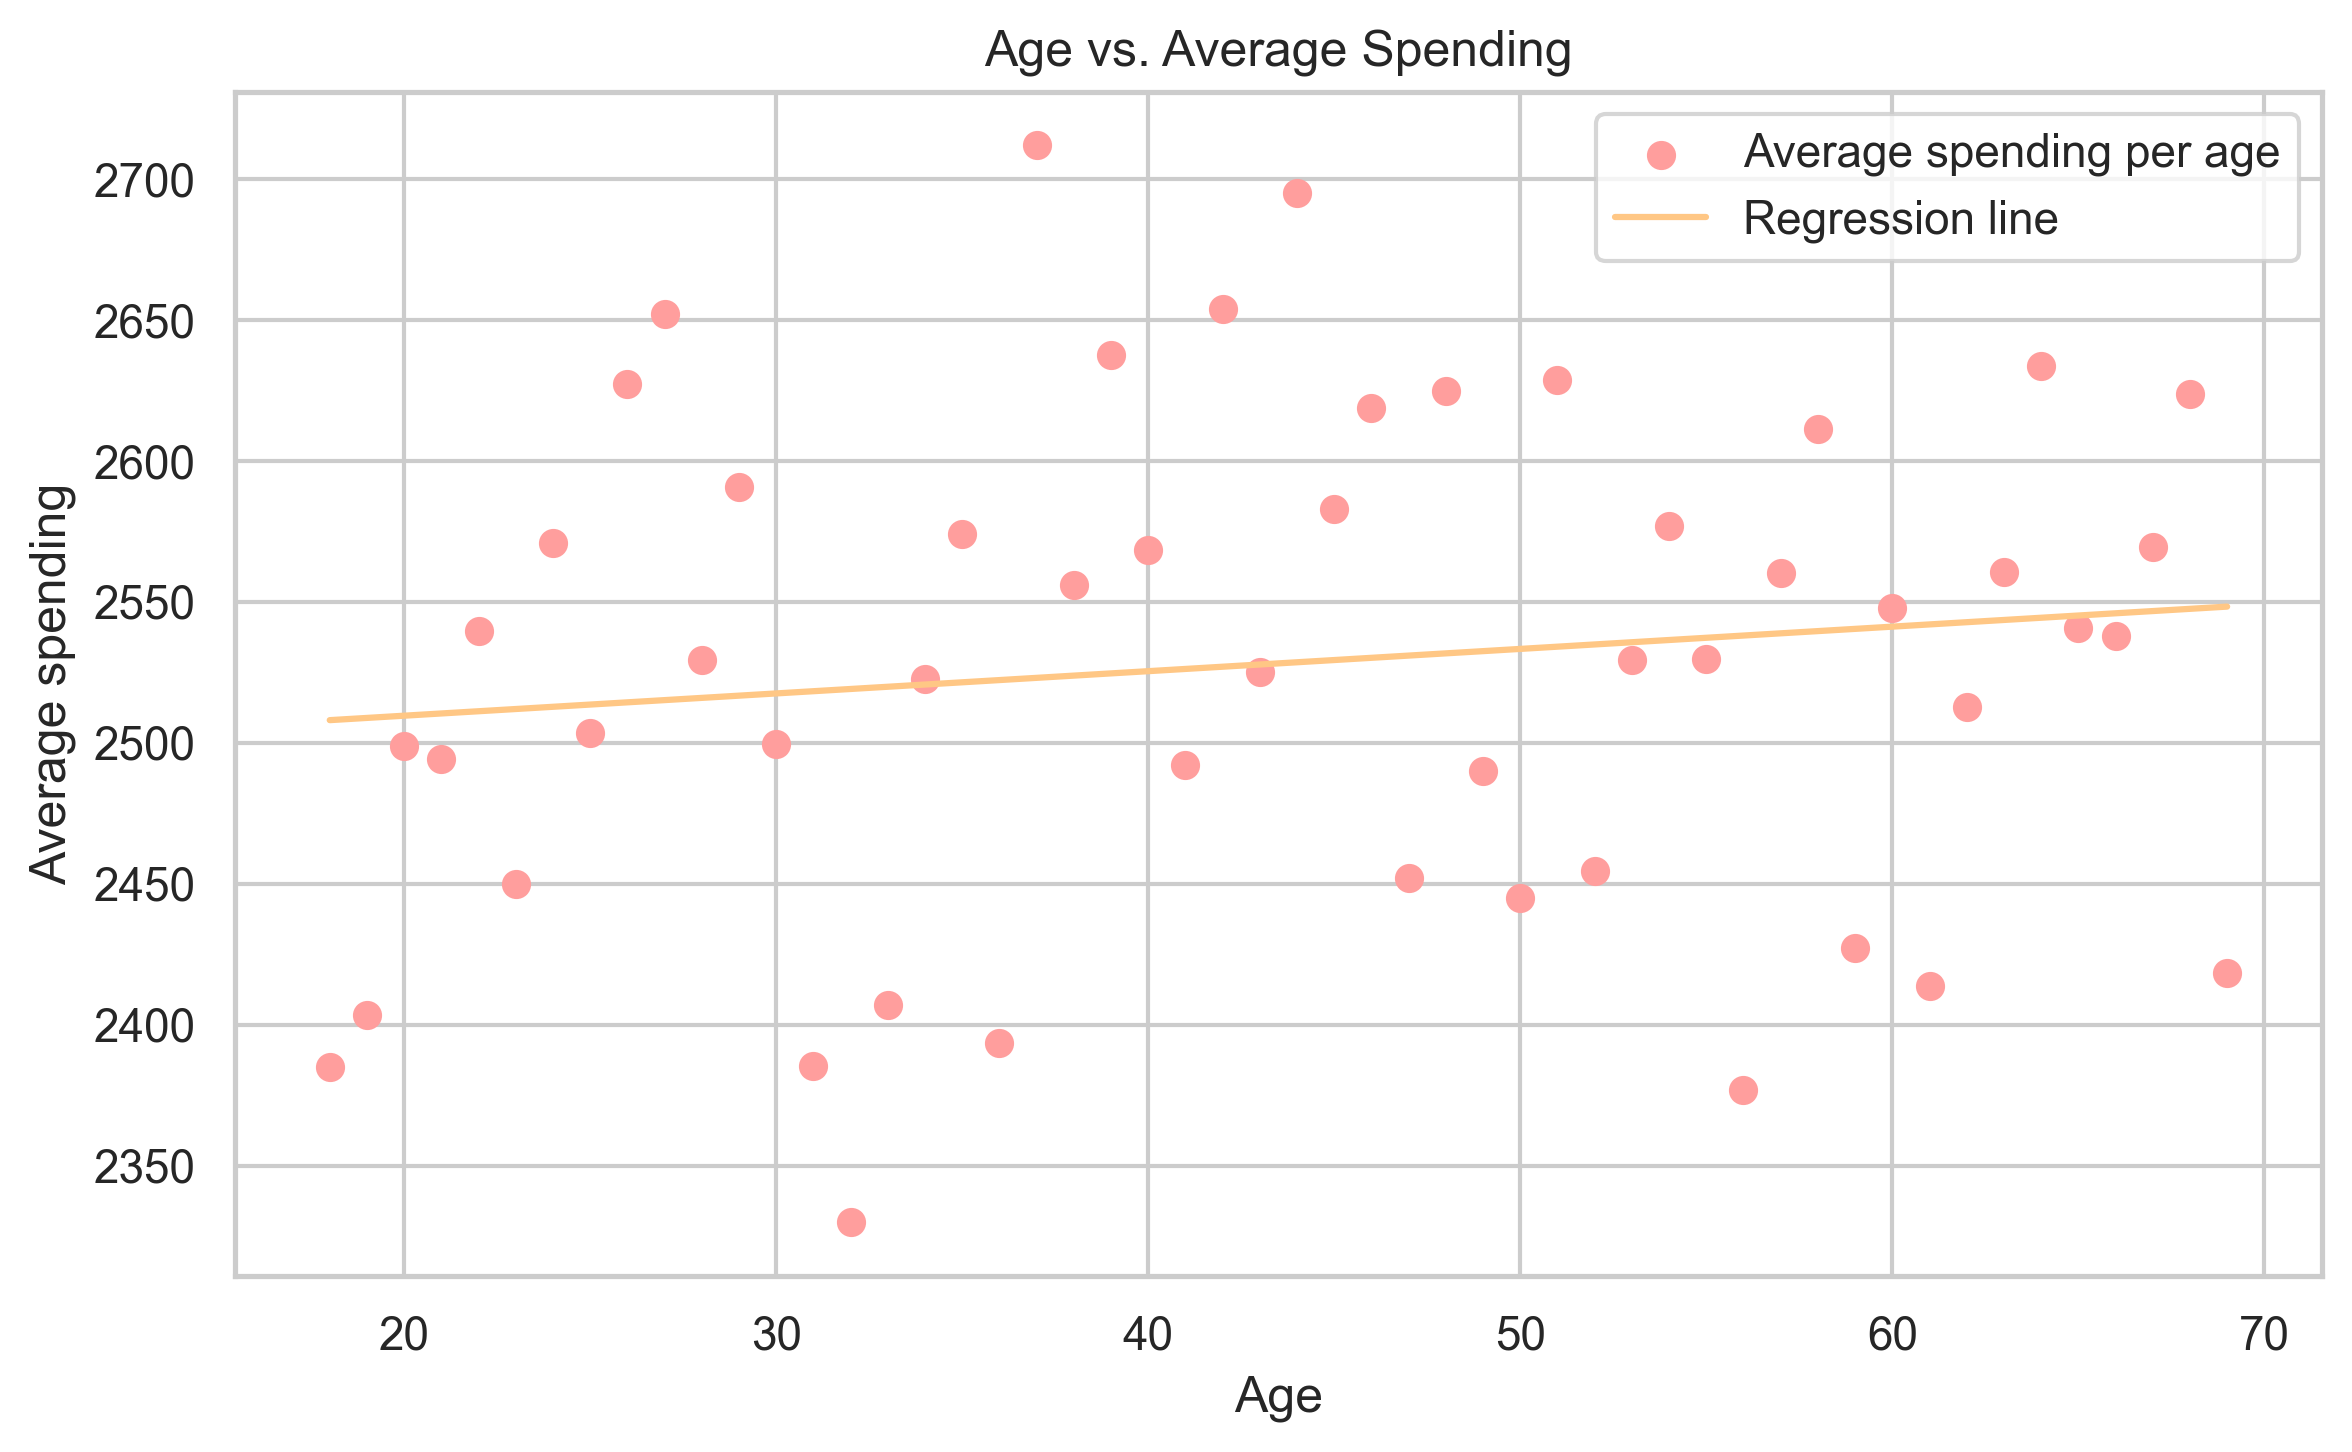

In [2]:
# Method: OLS Linear Regression to test if age is associated with average spending per age

# Group by age and calculate average spending
age_group = df.groupby("age")["total_price"].mean().reset_index()

# Prepare X and y
X = age_group["age"]
y = age_group["total_price"]

# Add constant term for intercept
X_const = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X_const).fit()

# Print regression summary
print(model.summary())

# Print interpretation of significance
p_value = model.pvalues["age"]

if p_value < 0.05:
    print(f"✅ Significant relationship: Age is associated with average spending per age. (p={p_value:.4f})")
else:
    print(f"❌ No significant relationship between age and average spending per age. (p={p_value:.4f})")

# Scatter plot with regression line
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=300)
plt.scatter(X, y, color=color1, label="Average spending per age")
plt.plot(X, model.predict(X_const), color=color2, label="Regression line")
plt.xlabel("Age")
plt.ylabel("Average spending")
plt.title("Age vs. Average Spending")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/age_total_spending.png', dpi=300)
plt.show()


2. age ↔ transaction_count <br>
Do younger or older customers shop more frequently?

    age  transaction_count
0    18               1844
1    19               1936
2    20               1844
3    21               1947
4    22               2051
5    23               1897
6    24               1977
7    25               1863
8    26               1896
9    27               1950
10   28               1953
11   29               1885
12   30               1981
13   31               1866
14   32               1891
15   33               1913
16   34               1883
17   35               1841
18   36               1954
19   37               2057
20   38               1954
21   39               1947
22   40               1960
23   41               1892
24   42               1892
25   43               2000
26   44               1904
27   45               1876
28   46               1911
29   47               1880
30   48               1955
31   49               1883
32   50               1873
33   51               1993
34   52               1945
35   53               1903
3

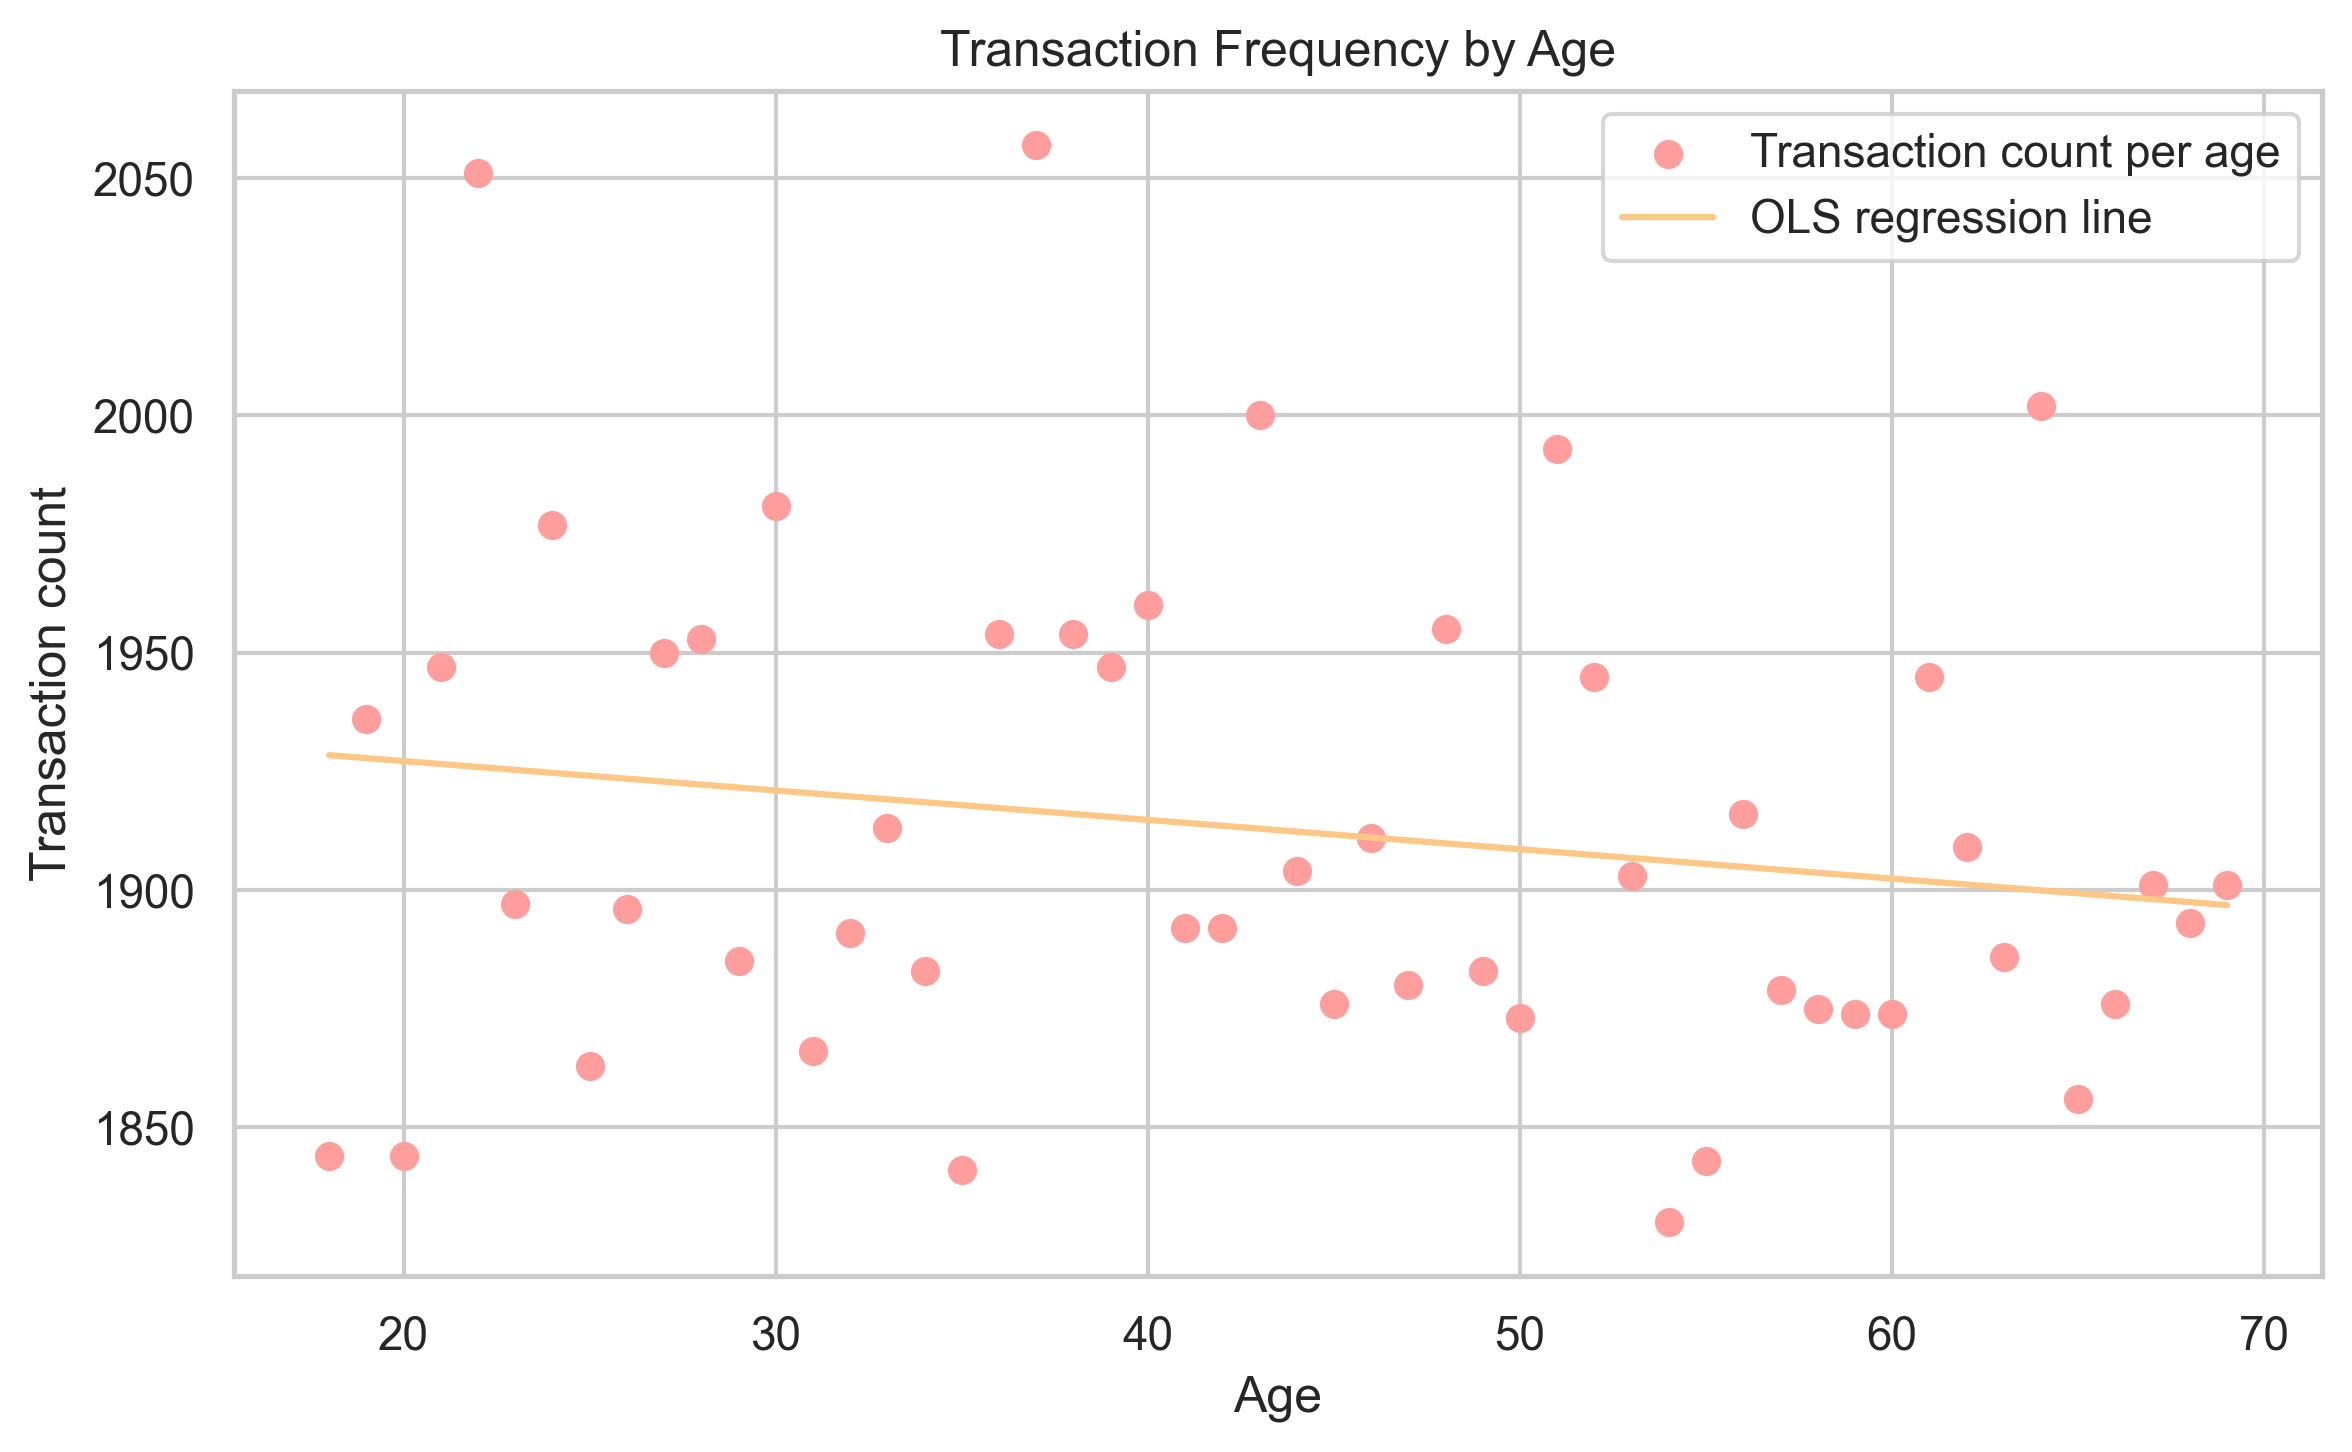

In [3]:
# Group by age and count transactions
age_txn = (
    df.groupby("age")
      .size()
      .reset_index(name="transaction_count")
)

# Display the counts to see which ages shop most
print(age_txn)

# Prepare X and y for regression
X = age_txn["age"]
y = age_txn["transaction_count"]

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Interpret significance
p_value = model.pvalues["age"]

if p_value < 0.05:
    print(f"✅ Significant relationship: Age is associated with transaction frequency. (p={p_value:.4f})")
else:
    print(f"❌ No significant relationship between age and transaction frequency. (p={p_value:.4f})")
    
# Scatter plot with regression line
plt.figure(figsize=(8,5), dpi=300)
plt.scatter(age_txn["age"], age_txn["transaction_count"], color=color1, label="Transaction count per age")
plt.plot(age_txn["age"], model.predict(sm.add_constant(age_txn["age"])), color=color2, label="OLS regression line")
plt.xlabel("Age")
plt.ylabel("Transaction count")
plt.title("Transaction Frequency by Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/age_transaction_count.png', dpi=300)
plt.show()

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   11
Model:                            RLM   Df Residuals:                        9
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 10 Jul 2025                                         
Time:                        11:36:44                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9760.4193    113.471     86.017      0.0

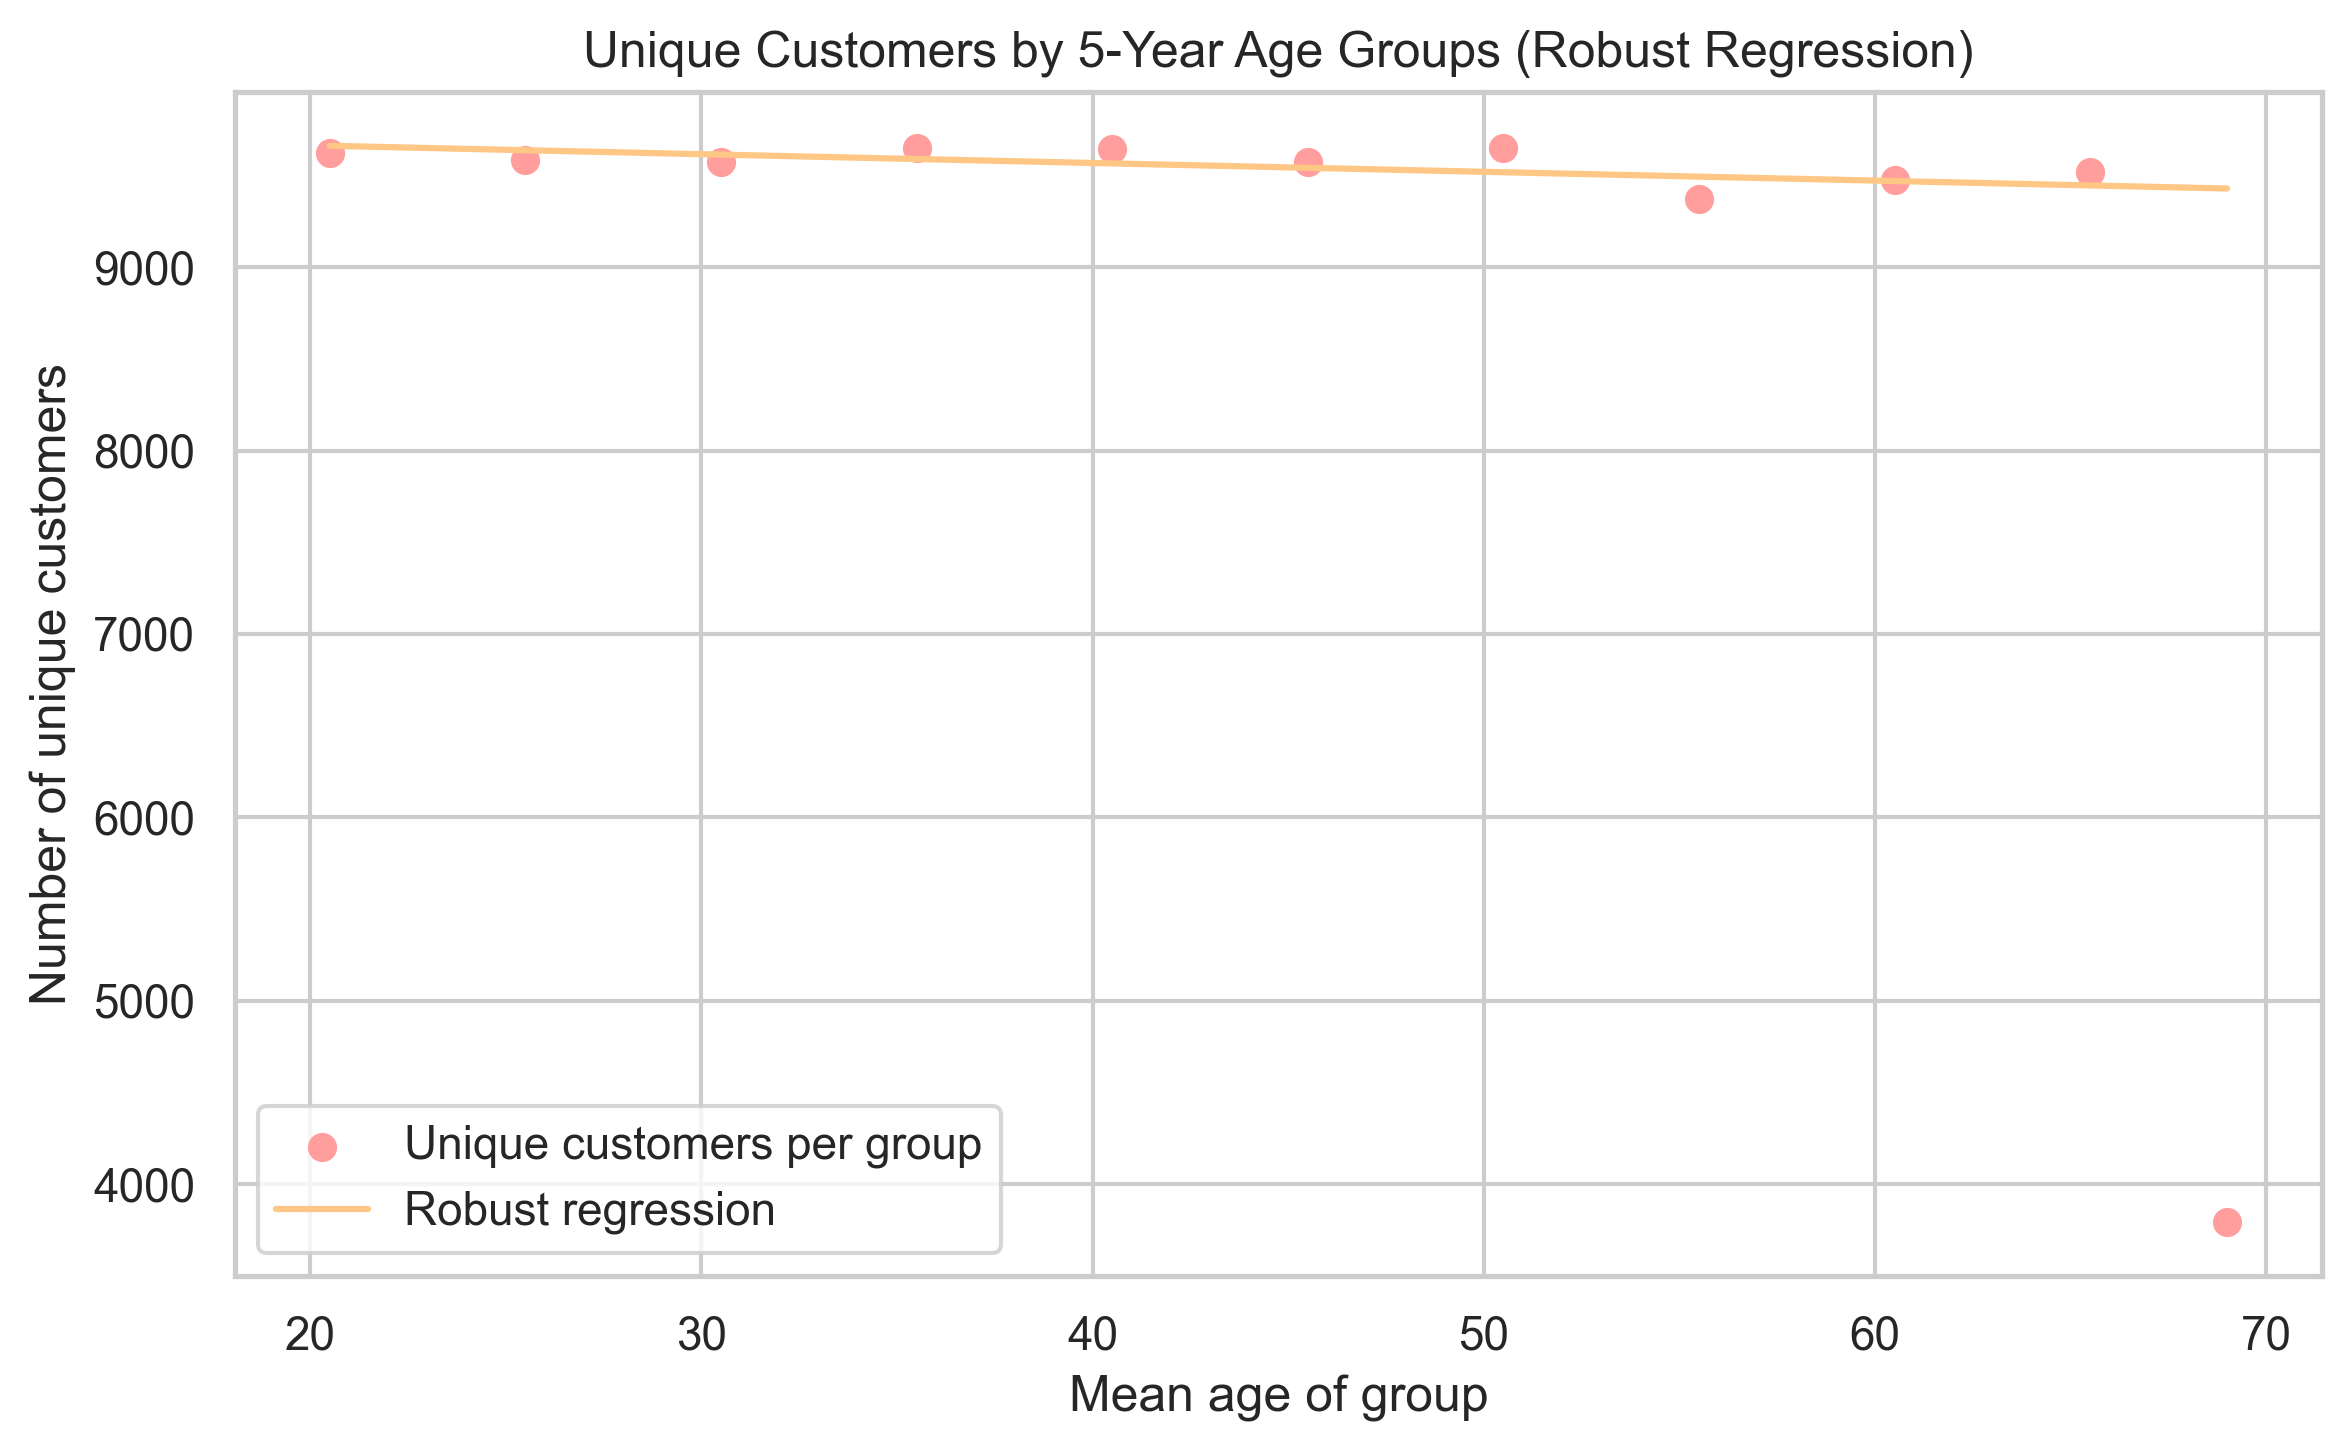

In [4]:
# Robust Regression on 5-year binned unique customer counts
# This approach minimizes the influence of outlier groups and provides more stable estimates.

# Define 5-year bins
bins = list(range(18, 70, 5))
if bins[-1] < 69:
    bins.append(70)

# Assign age groups
df["age_group"] = pd.cut(
    df["age"],
    bins=bins,
    right=False
)

# Count unique customers per age group
group_counts = df.groupby("age_group", observed=False).size()

# Compute midpoints
intervals = df["age_group"].cat.categories
mean_ages = [interval.mid for interval in intervals]

# Remove empty groups
mean_ages_filtered = [mean_ages[i] for i in range(len(mean_ages)) if not pd.isna(group_counts.values[i])]
y_filtered = group_counts[~group_counts.isna()].values

X = np.array(mean_ages_filtered)

# Robust regression
X_const = sm.add_constant(X)
model_rlm = sm.RLM(y_filtered, X_const).fit()

# Print summary
print(model_rlm.summary())

# Get p-value (z-test) for slope
p_value = model_rlm.pvalues[1]

# Interpretation
if p_value < 0.05:
    print(f"✅ Significant relationship between mean age and customer count. p={p_value:.4f}")
else:
    print(f"❌ No significant relationship between mean age and customer count. p={p_value:.4f}")

# Scatter and regression line
plt.figure(figsize=(8,5), dpi=300)
plt.scatter(X, y_filtered, color=color1, label="Unique customers per group")
plt.plot(X, model_rlm.predict(X_const), color=color2, label="Robust regression")
plt.xlabel("Mean age of group")
plt.ylabel("Number of unique customers")
plt.title("Unique Customers by 5-Year Age Groups (Robust Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/age_groups_transaction_count_robust.png', dpi=300)
plt.show()


3. gender ↔ total_spend <br>
Is there a difference in spending levels between men and women?

In [5]:
# Given that the descriptive statistics by gender show extremely similar means and standard deviations across key monetary variables, 
# there is a possibility that the dataset may be synthetic or anonymized with standardized distributions. This should be considered when interpreting the results. 
# 1. Customer-level total spend
customer_spend = (
    df.groupby(['customer_id', 'gender'])['total_price']
      .sum()
      .reset_index(name='total_spend')
)
customer_spend.groupby('gender')['total_spend'].describe()


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,59482.0,2525.253623,4226.617822,5.23,136.35,600.17,2700.72,26250.0
Male,39975.0,2534.050237,4216.352329,5.23,130.75,600.17,2700.72,26250.0


                            OLS Regression Results                            
Dep. Variable:            total_spend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1038
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.747
Time:                        11:36:45   Log-Likelihood:            -9.7141e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99455   BIC:                         1.943e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2525.2536     17.31

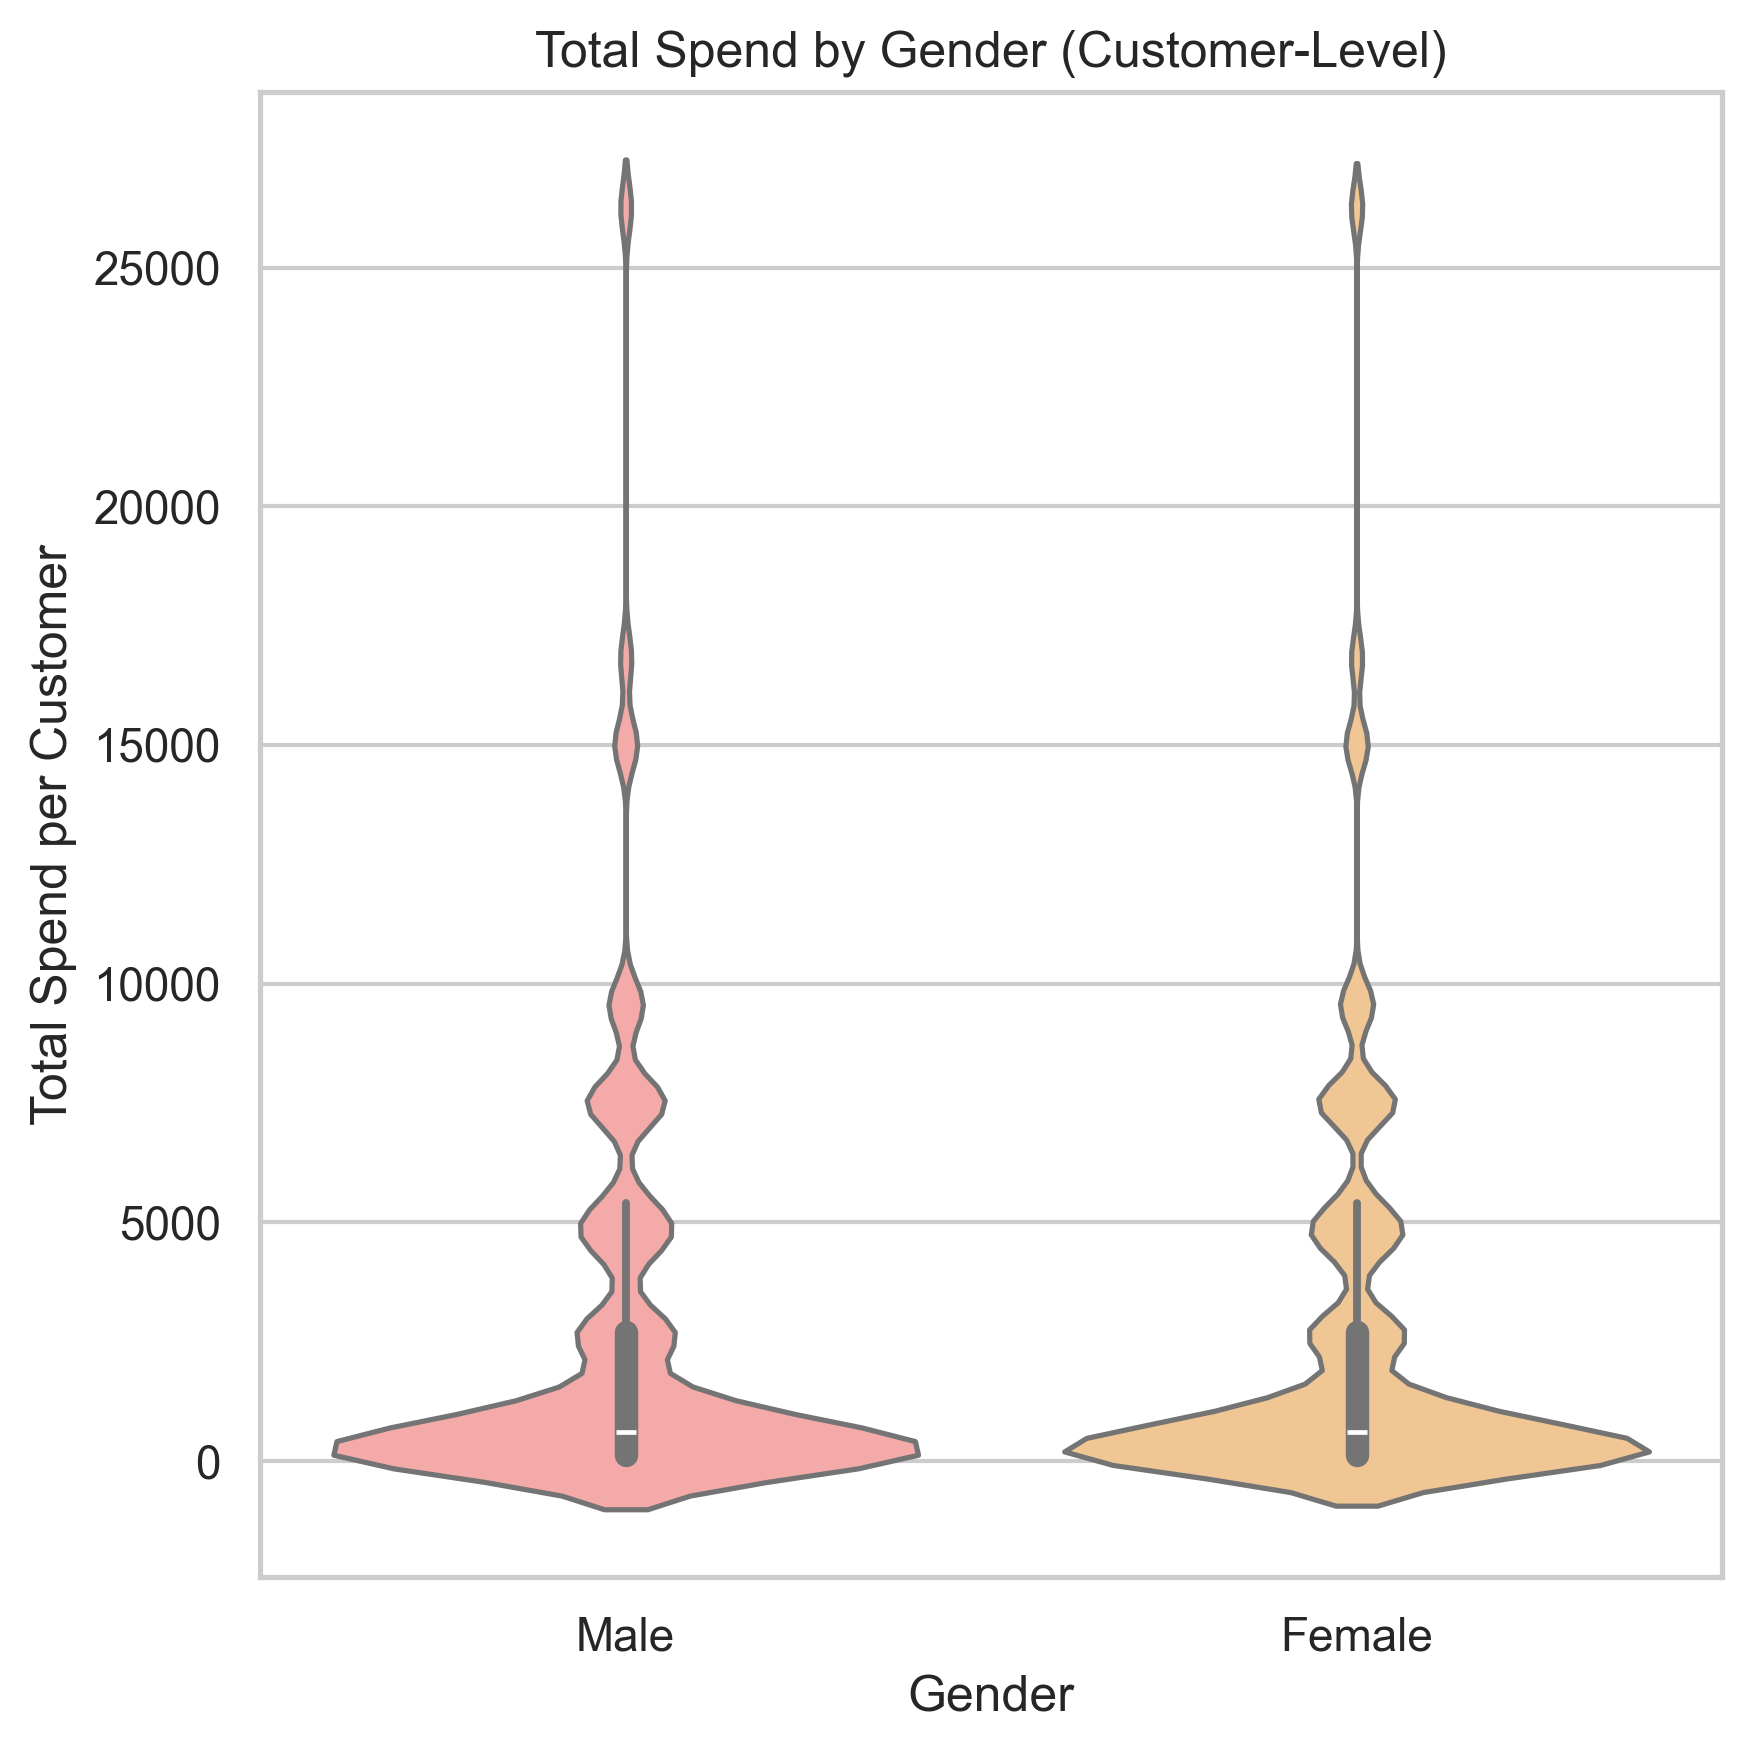

In [6]:
# The distributions of total spending by gender are very similar; data may be synthetic or standardized. Interpret with caution.

# 1. Customer-level total spend
customer_spend = (
    df.groupby(['customer_id', 'gender'])['total_price']
      .sum()
      .reset_index(name='total_spend')
)

# 2. OLS regression
model = smf.ols('total_spend ~ C(gender)', data=customer_spend).fit()

# Print regression summary
print(model.summary())

# Interpret significance
p_value = model.pvalues['C(gender)[T.Male]']

if p_value < 0.05:
    print(f"✅ Significant difference: Gender is associated with total spending.  (p={p_value:.4f})")
else:
    print(f"❌ No significant difference in total spending between genders.  (p={p_value:.4f})")

# 3. Violin plot
plt.figure(figsize=(6,6), dpi=300)
sns.violinplot(
    x='gender',
    y='total_spend',
    hue='gender',
    data=customer_spend,
    palette={'Male': color1, 'Female': color2},
    inner='box'   # Show median and quartiles
)
plt.xlabel("Gender")
plt.ylabel("Total Spend per Customer")
plt.title("Total Spend by Gender (Customer-Level)")
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/gender_total_spend.png', dpi=300)
plt.show()

6. gender ↔ category <br>
Do product category preferences vary by gender?

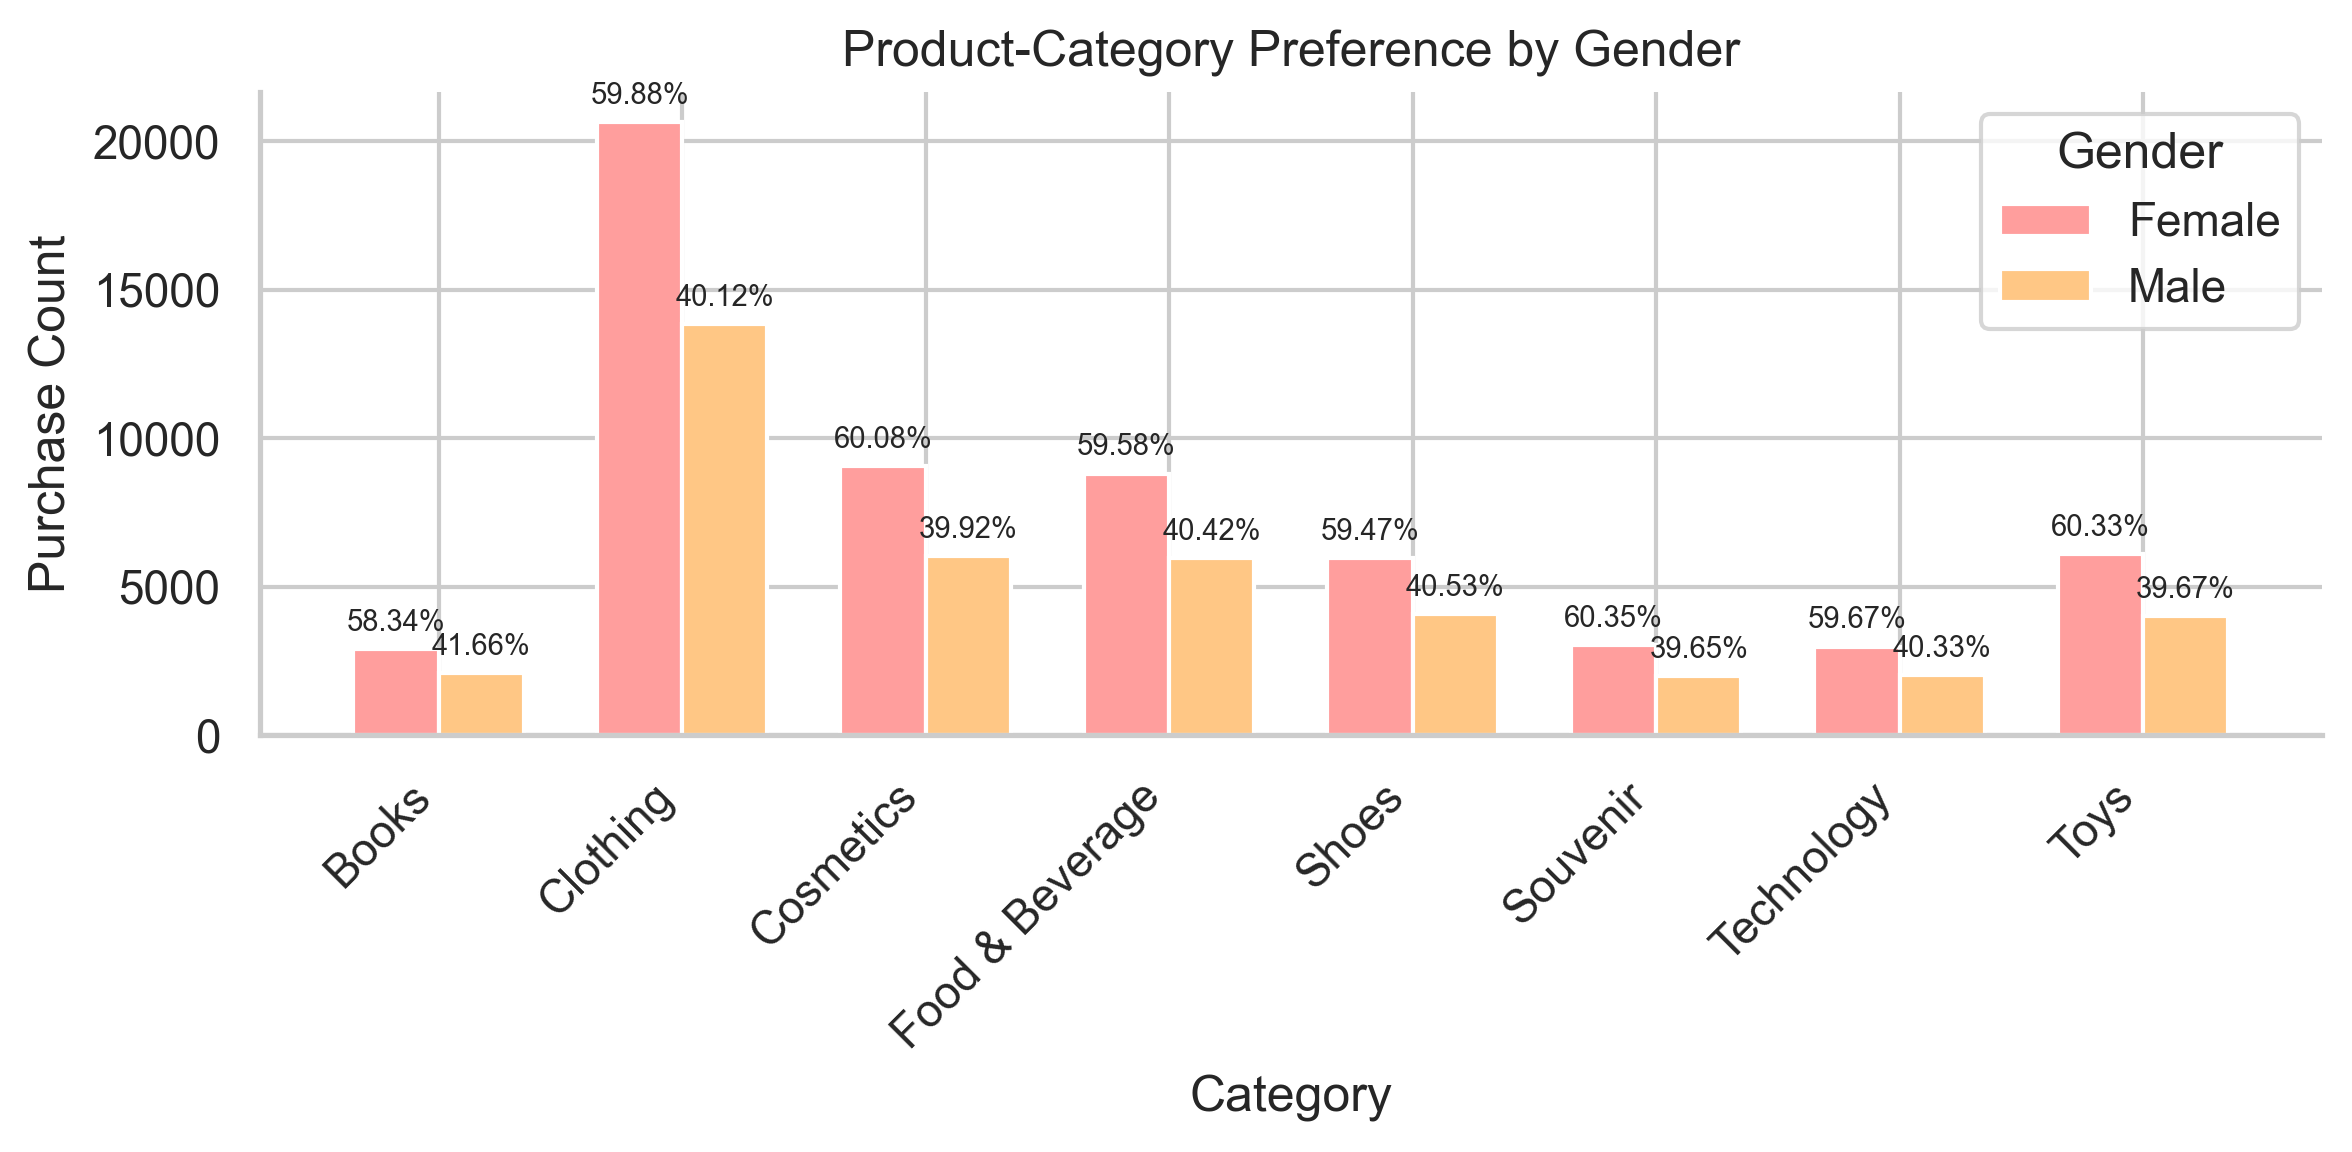


Observed counts (purchases by category and gender):

gender           Female   Male
category                      
Books              2906   2075
Clothing          20652  13835
Cosmetics          9070   6027
Food & Beverage    8804   5972
Shoes              5967   4067
Souvenir           3017   1982
Technology         2981   2015
Toys               6085   4002

Expected counts under the null hypothesis (no association):

gender             Female      Male
category                           
Books             2978.97   2002.03
Clothing         20625.55  13861.45
Cosmetics         9029.03   6067.97
Food & Beverage   8837.05   5938.95
Shoes             6001.01   4032.99
Souvenir          2989.74   2009.26
Technology        2987.95   2008.05
Toys              6032.71   4054.29

Chi-squared test results:
χ² = 7.5679   (df = 7)
p = 0.3722
❌ No significant association: Gender does not affect product-category preferences.


In [7]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS 6: Do product-category preferences vary by gender?  ║
# ╚══════════════════════════════════════════════════════════════╝

# Crosstab of category vs gender
ct = pd.crosstab(df["category"], df["gender"])

cats = ct.index.tolist()
genders = ["Female", "Male"]
gender_colors = {"Female": color1, "Male": color2}
x = np.arange(len(cats))
width = 0.35

# Bar plot
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
for i, g in enumerate(genders):
    counts = ct[g].values
    barpos = x + (i - 0.5) * width
    ax.bar(barpos, counts, width=width,
           color=gender_colors[g], label=g)
    pct = (counts / ct.sum(axis=1).values) * 100
    for j, (c, pcent) in enumerate(zip(counts, pct)):
        ax.text(barpos[j], c + max(ct.values.max() * 0.02, 1),
                f"{pcent:.2f}%", ha="center", va="bottom", fontsize=7)

ax.set_xticks(x)
ax.set_xticklabels(cats, rotation=45, ha="right")
ax.set_ylabel("Purchase Count")
ax.set_xlabel("Category")
ax.set_title("Product-Category Preference by Gender")
ax.legend(title="Gender")
sns.despine()
plt.tight_layout()
plt.savefig("dataset_customer_analysis_figures/gender_category.png", dpi=300)
plt.show()

# Chi-squared test
chi2, p, dof, exp = stats.chi2_contingency(ct)

# Expected counts DataFrame
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

# Print results in clean format
print("\nObserved counts (purchases by category and gender):\n")
print(ct)

print("\nExpected counts under the null hypothesis (no association):\n")
print(expected_df.round(2))

print("\nChi-squared test results:")
print(f"χ² = {chi2:.4f}   (df = {dof})")
print(f"p = {p:.4f}")

if p < 0.05:
    print("✅ Significant association: Product-category preferences differ by gender.")
else:
    print("❌ No significant association: Gender does not affect product-category preferences.")


7. age_group ↔ category <br>
Do product category preferences change significantly by age group

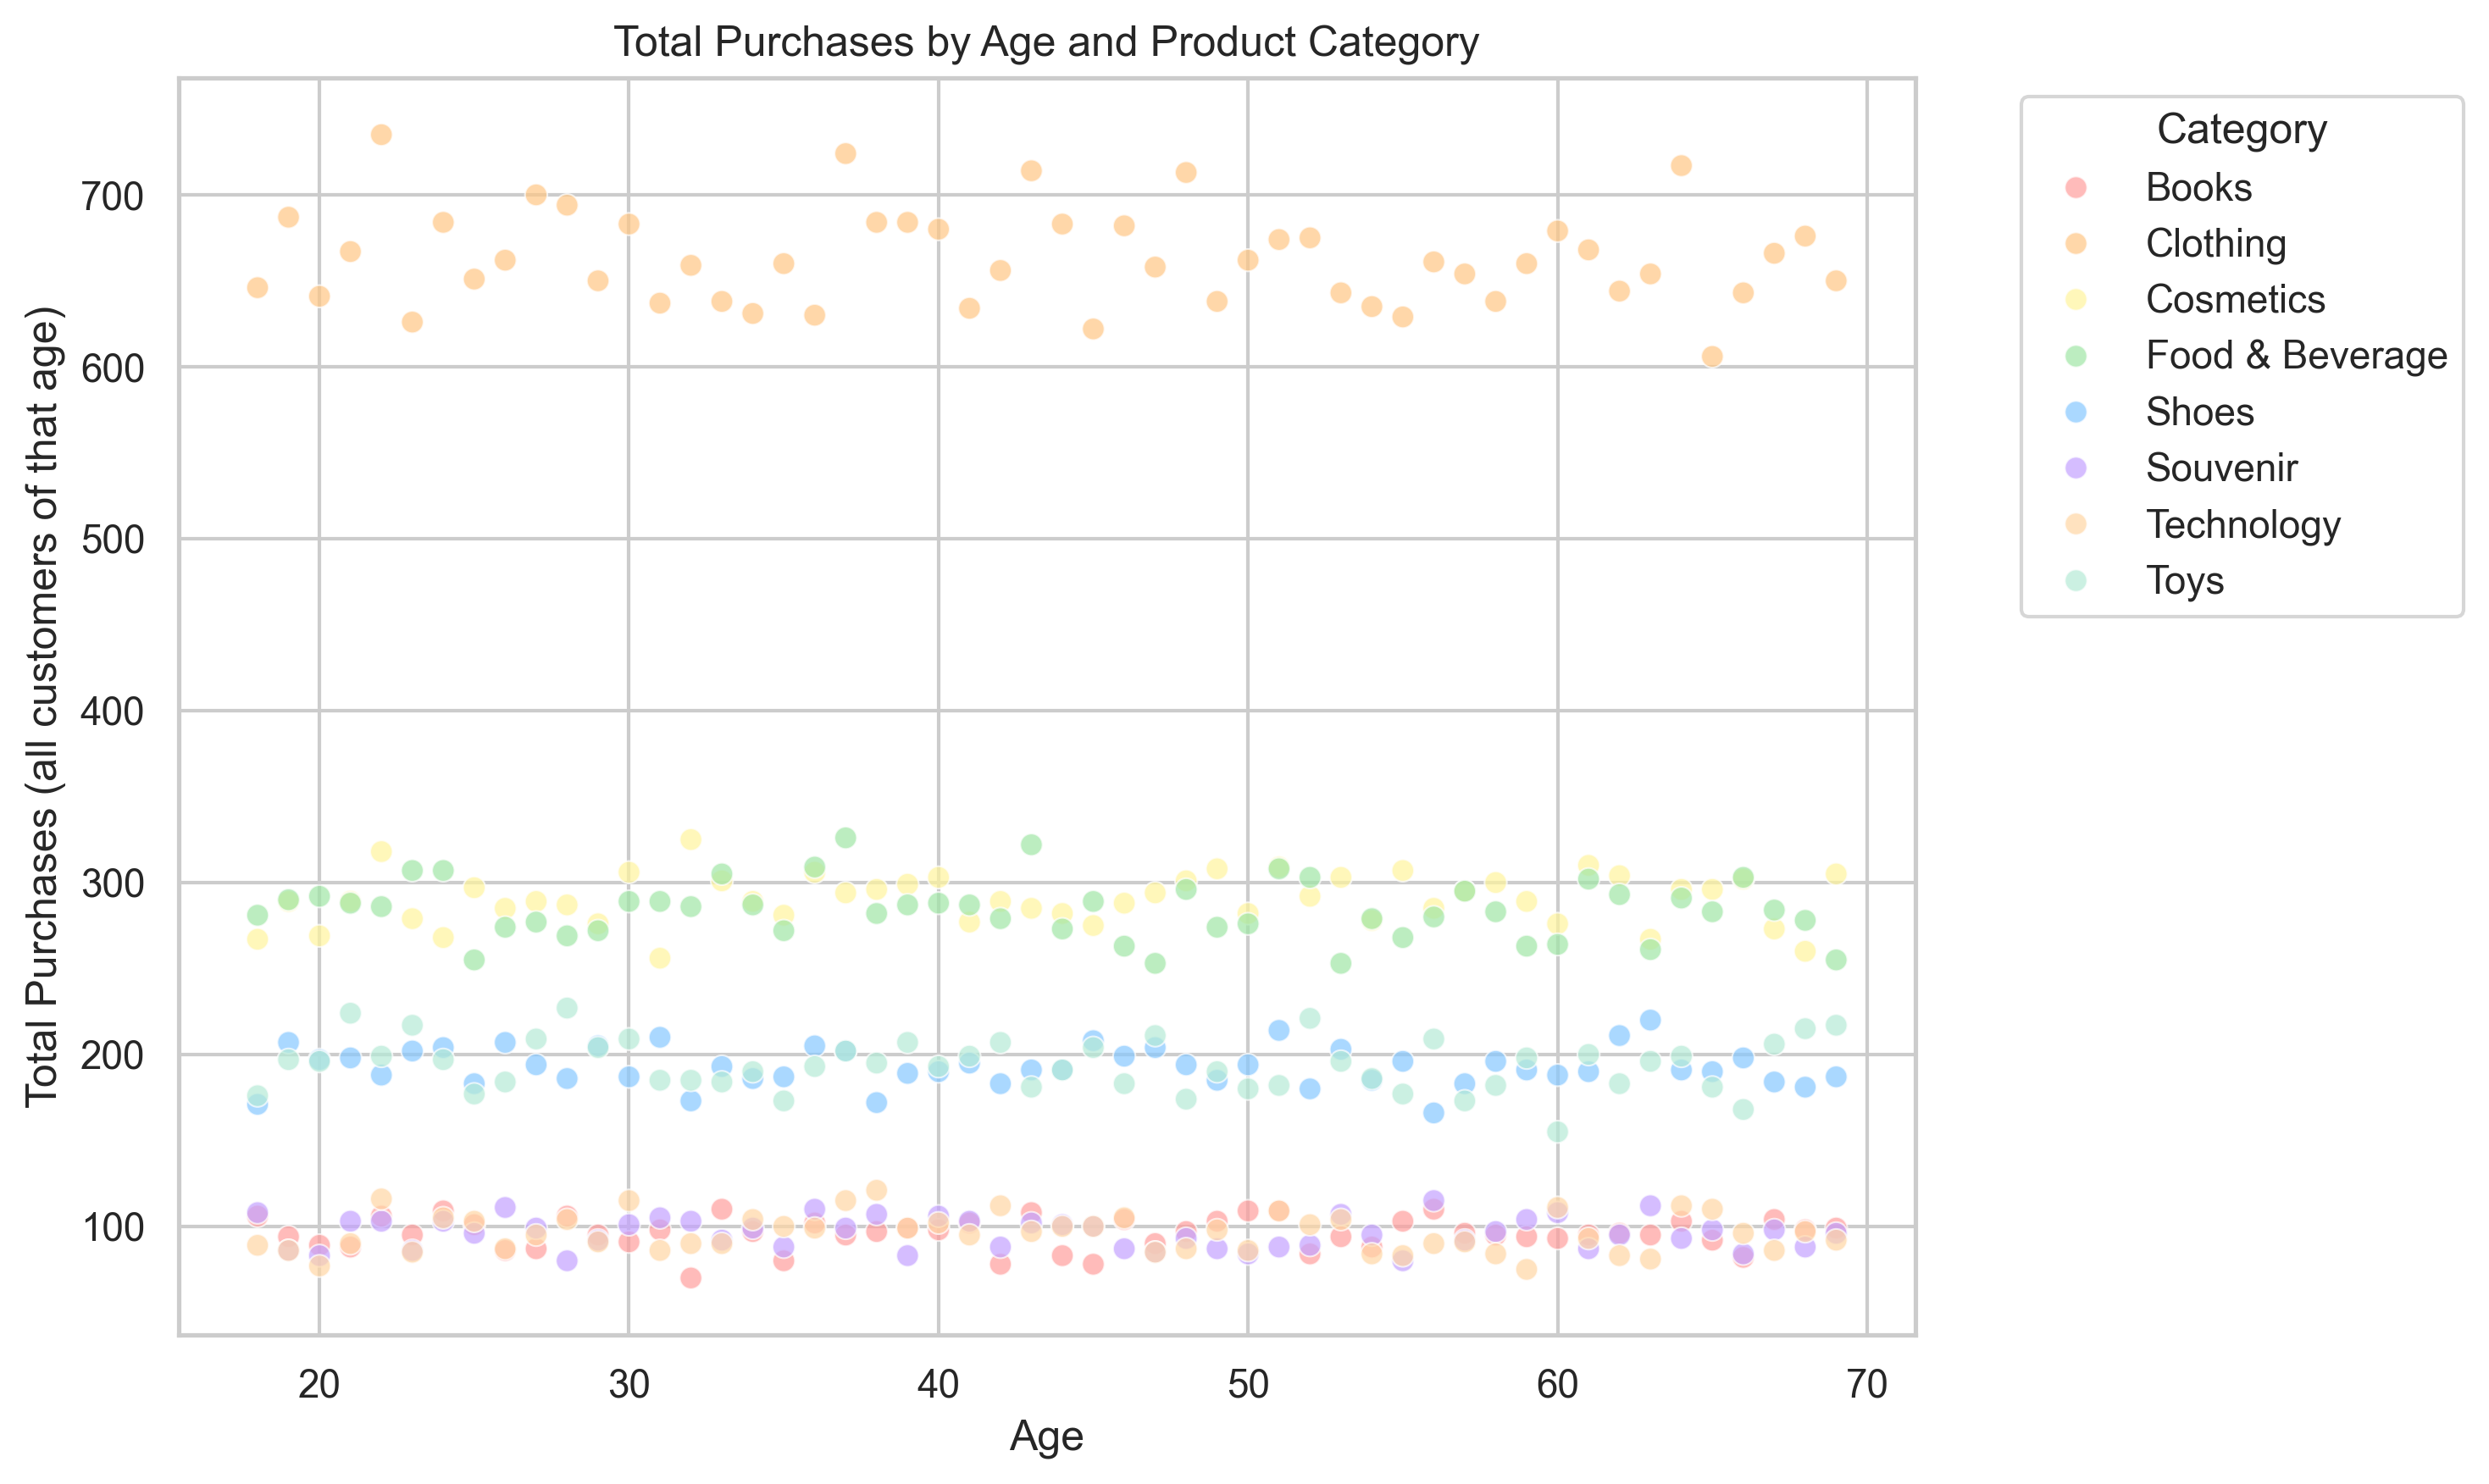


Category: Books
                            OLS Regression Results                            
Dep. Variable:         purchase_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                   0.04323
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.836
Time:                        11:36:46   Log-Likelihood:                -188.54
No. Observations:                  52   AIC:                             381.1
Df Residuals:                      50   BIC:                             385.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0141      3.940   

In [8]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS 7: Category preferences by exact age (no binning)   ║
# ╚══════════════════════════════════════════════════════════════╝

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: total purchases per age and category
age_category_counts = (
    df.groupby(["age", "category"])
      .size()
      .reset_index(name="purchase_count")
)

# Custom colors for 8 categories
category_colors = [
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8
]

unique_categories = age_category_counts["category"].unique()
palette_dict = dict(zip(sorted(unique_categories), category_colors))

# Scatter plot: age vs total purchase count per category
plt.figure(figsize=(10,6), dpi=300)
sns.scatterplot(
    data=age_category_counts,
    x="age",
    y="purchase_count",
    hue="category",
    palette=palette_dict,
    alpha=0.7,
    s=40
)
plt.xlabel("Age")
plt.ylabel("Total Purchases (all customers of that age)")
plt.title("Total Purchases by Age and Product Category")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/age_category.png', dpi=300)
plt.show()

# Unique categories
categories = sorted(age_category_counts["category"].unique())

# Results dictionary
results = {}

for cat in categories:
    df_cat = age_category_counts[age_category_counts["category"] == cat]
    
    X = df_cat["age"]
    y = df_cat["purchase_count"]
    
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    
    results[cat] = model
    
    print(f"\nCategory: {cat}")
    print(model.summary())
    
    p_value = model.pvalues["age"]
    if p_value < 0.05:
        print(f"✅ Significant relationship between age and purchase count. p={p_value:.4f}")
    else:
        print(f"❌ No significant relationship between age and purchase count. p={p_value:.4f}")



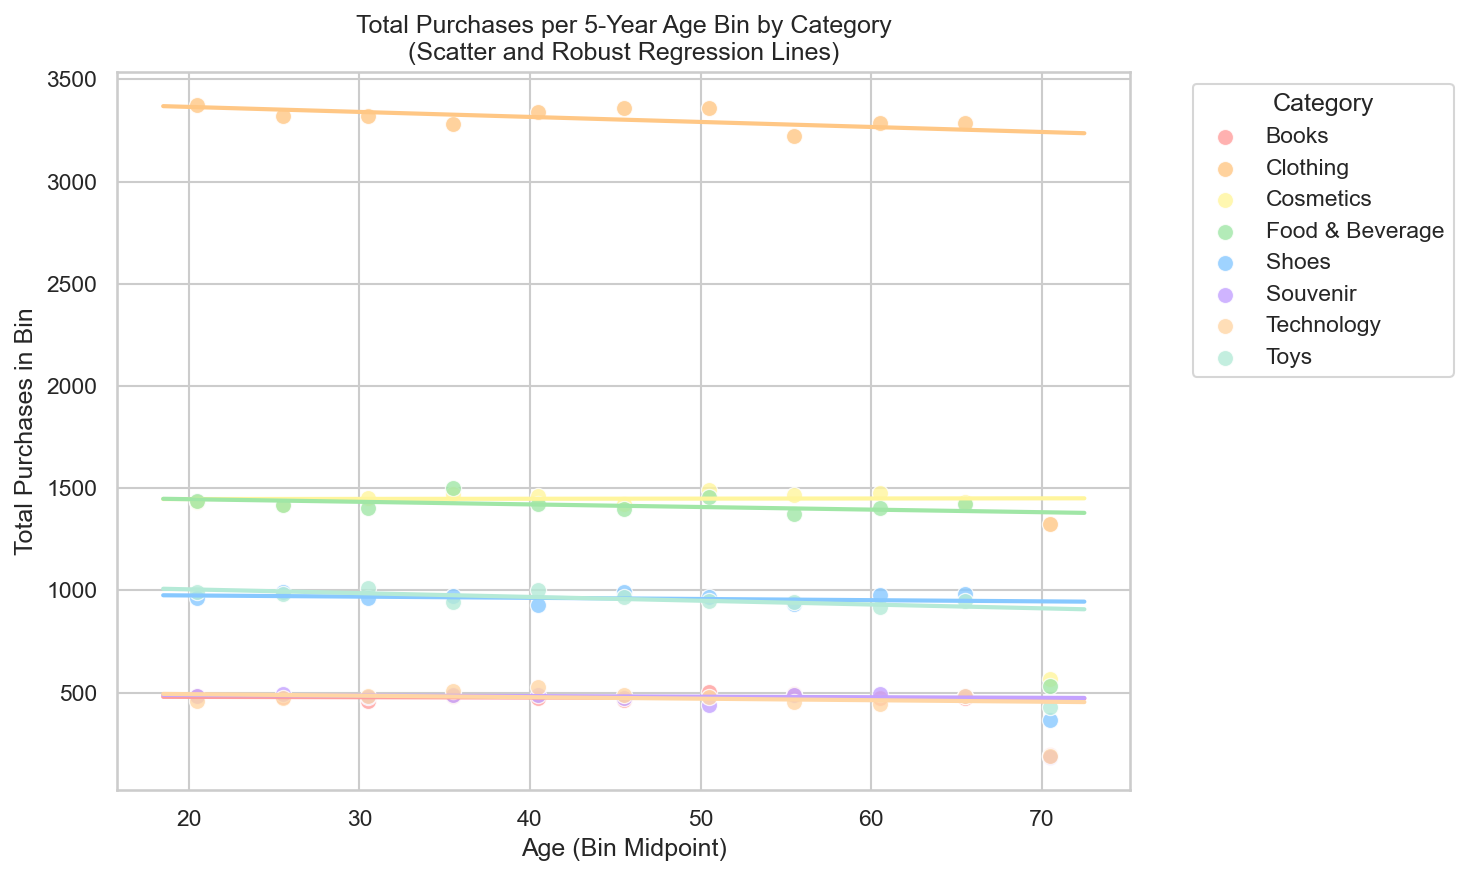


--- ROBUST LINEAR REGRESSION RESULTS BY CATEGORY ---

Category: Books
                     Robust linear Model Regression Results                     
Dep. Variable:     total_purchase_count   No. Observations:                   11
Model:                              RLM   Df Residuals:                        9
Method:                            IRLS   Df Model:                            1
Norm:                            HuberT                                         
Scale Est.:                         mad                                         
Cov Type:                            H1                                         
Date:                  Thu, 10 Jul 2025                                         
Time:                          11:36:46                                         
No. Iterations:                      17                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [9]:
# 5-year bins
age_bins = list(range(18, 70, 5))
if age_bins[-1] < 69:
    age_bins.append(70)

age_labels = [f"{b}-{b+4}" for b in age_bins[:-1]]

# Age group column
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

# Aggregate: total purchases per bin and category
age_category_counts_binned = (
    df.groupby(["age_group", "category"], observed=False)
      .size()
      .reset_index(name="total_purchase_count")
)

# Compute bin midpoints
bin_midpoints = [b + 2.5 for b in age_bins[:-1]]
bin_midpoint_map = dict(zip(age_labels, bin_midpoints))
age_category_counts_binned["age_midpoint"] = age_category_counts_binned["age_group"].map(bin_midpoint_map)

# Custom colors
category_colors = [
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8
]

unique_categories = sorted(age_category_counts_binned["category"].unique())
palette_dict = dict(zip(unique_categories, category_colors))

# Scatter plot with robust regression lines
plt.figure(figsize=(10,6), dpi=150)

x_range = np.linspace(min(bin_midpoints)-2, max(bin_midpoints)+2, 100)

for cat in unique_categories:
    df_cat = age_category_counts_binned[age_category_counts_binned["category"] == cat]
    color = palette_dict[cat]
    
    # Scatter
    sns.scatterplot(
        data=df_cat,
        x="age_midpoint",
        y="total_purchase_count",
        color=color,
        label=cat,
        s=60,
        alpha=0.8
    )
    
    # Robust regression line
    X = df_cat["age_midpoint"]
    y = df_cat["total_purchase_count"]
    X_const = sm.add_constant(X)
    
    model = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()
    y_pred = model.predict(sm.add_constant(x_range))
    
    plt.plot(x_range, y_pred, color=color, linewidth=2)

plt.xlabel("Age (Bin Midpoint)")
plt.ylabel("Total Purchases in Bin")
plt.title("Total Purchases per 5-Year Age Bin by Category\n(Scatter and Robust Regression Lines)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('dataset_customer_analysis_figures/age_group_category.png', dpi=300)
plt.show()

# Robust regression summaries
print("\n--- ROBUST LINEAR REGRESSION RESULTS BY CATEGORY ---")
for cat in unique_categories:
    df_cat = age_category_counts_binned[age_category_counts_binned["category"] == cat]
    
    X = df_cat["age_midpoint"]
    y = df_cat["total_purchase_count"]
    
    X_const = sm.add_constant(X)
    
    model = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()
    
    print(f"\nCategory: {cat}")
    print(model.summary())
    
    p_value = model.pvalues["age_midpoint"]
    if p_value < 0.05:
        print(f"✅ Significant relationship between age and total purchases (robust). p={p_value:.4f}")
    else:
        print(f"❌ No significant relationship between age and total purchases (robust). p={p_value:.4f}")


8. gender ↔ shopping_mall <br>
Does the distribution of shoppers across shopping malls differ by gender?

In [10]:
# Contingency table: Gender vs Shopping Mall
contingency_table = pd.crosstab(
    df["gender"],
    df["shopping_mall"]
)

print("Contingency Table:")
print(contingency_table)

# Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.4f}")

# Interpretation
if p < 0.05:
    print(f"✅ Significant association: Shopping mall preferences differ by gender. (p={p:.4f})")
else:
    print(f"❌ No significant association between gender and shopping mall preference. (p={p:.4f})")


Contingency Table:
shopping_mall  Cevahir AVM  Emaar Square Mall  Forum Istanbul  Istinye Park  \
gender                                                                        
Female                2940               2842            3016          5874   
Male                  2051               1969            1931          3907   

shopping_mall  Kanyon  Mall of Istanbul  Metrocity  Metropol AVM  \
gender                                                             
Female          11906             11902       8941          6144   
Male             7917              8041       6070          4017   

shopping_mall  Viaport Outlet  Zorlu Center  
gender                                       
Female                   2949          2968  
Male                     1965          2107  

Chi-Square Test Results:
Chi2 statistic = 12.45
Degrees of freedom = 9
p-value = 0.1893
❌ No significant association between gender and shopping mall preference. (p=0.1893)
